# TRAFFIC SIGN RECOGNITION GERMAN DATASET

## INDICE
 0. CARGA DE DATOS
 1. MODELO
 2. VISUALIZACIÓN DE LOS PESOS
 3. CONFUSSION MATRIX
 4. PORCENTAJE DE ACIERTOS

## 1. CARGA DE DATOS

In [1]:
import os
import random
import skimage.data
import skimage.transform
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import csv
import math

# Allow image embeding in notebook
%matplotlib inline

In [2]:
def load_data(data_dir):
    directories = [d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d))]

    labels = []
    images = []
    #print(directories)
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f) 
                      for f in os.listdir(label_dir) if f.endswith(".ppm")]
        for f in file_names:
            images.append(skimage.data.imread(f))
            labels.append(int(d))
    
    images32 = [skimage.transform.resize(image, (32, 32))for image in images]
    
    labels2=np.array(labels)
    images2=np.array(images32)
    
    #print(label_dir)
    return images2, labels2

In [3]:
train_data_dir = ".\\data\\Training"            
X_train_orig, Y_train_orig = load_data(train_data_dir)
#print(Y_train_orig)

D:\ANACONDA\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [4]:
def load_test_data (data_dir):
    labels  = []
    labels2 =[]
    images = []
    
    with open('GT-final_test.csv', 'r') as f:
      reader = csv.reader(f)
      labels = list(reader)
    #print(labels)
    for d in range(1,len(labels)):
        labels2.append(int(labels[d][0]))
    #print(len(labels))
    
    file_names = [os.path.join(data_dir, f) 
                  for f in os.listdir(data_dir) if f.endswith(".ppm")]
    for f in file_names:
        images.append(skimage.data.imread(f))
        
    images32 = [skimage.transform.resize(image, (32, 32))
                for image in images]
    
    labels3=np.array(labels2)
    images2=np.array(images32)
    
    return images2,labels3

In [5]:
test_data_dir = ".\\data\\Testing" 
X_test_orig, Y_test_orig = load_test_data(test_data_dir)

D:\ANACONDA\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


## 2. Model 2: Leaky-ReLU & Minibatches

In [6]:
# TensorFlow doesn't have a native implementation of Leaky-ReLU
# that I know of. But it's simple enough to add it.
def lrelu(x):
    return tf.maximum(0.01*x,x)

PRUB CON 62 NODOS

In [7]:
class Model2():

    def __init__(self):
        self.graph = tf.Graph()
        with self.graph.as_default():
            #Global setp counter
            self.global_step = tf.Variable(0, trainable=False,name='global_step')
            #Placeholders
            self.images=tf.placeholder(tf.float32,(None,32, 32,3), name='images')
            self.labels=tf.placeholder(tf.int32, [None], name='labels')
            #Flatten input
            self.images_flat=tf.contrib.layers.flatten(self.images)
            #Fully connected layer
            self.logits=tf.contrib.layers.fully_connected(self.images_flat,62, lrelu)
            #Convert one hot vector to label indexes (int)
            self.predicted_labels=tf.argmax(self.logits,1)
            #Loss
            self.loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
                    logits=self.logits, labels=self.labels))
            #Training
            # Notice that we're passing the gloal_step variable as a parameter.
            # The minimize() function increments it with every training step.
            self.train=tf.train.AdamOptimizer(learning_rate=0.001)\
                        .minimize(self.loss, global_step=self.global_step)
            #Initialization
            self.init=tf.global_variables_initializer()
            #Create session
            self.session=tf.Session()
            #Run Initialization
            self.session.run(self.init)

In [20]:
def evaluate(model, images, labels, imprimir=True):
    #Run predictions against the full test set
    #print(images.shape)
    #print(labels.shape)
    predicted, loss = model.session.run([model.predicted_labels, model.loss],
                                       {model.images: images, model.labels:labels})
    #Calculate accuracy and print
    accuracy=np.sum(labels == predicted)/labels.shape[0]

    return loss, accuracy  

def train_minibatch(model, images, labels, test_images, test_labels, train_counts, imprimir=True):
    #Training loop
    costs_test=[]
    acc_test=[]
    costs_train=[]
    acc_train=[]
    for i in range(train_counts):
        if i % 10 == 0:
            loss_test, accuracy_test = evaluate(model, test_images, test_labels, imprimir)
            costs_test.append(loss_test)
            acc_test.append(accuracy_test)
            loss_train, accuracy_train = evaluate(model, images, labels, imprimir)
            costs_train.append(loss_train)
            acc_train.append(accuracy_train)
            a = model.session.run(model.global_step)
            if imprimir == True:
                print("{:4}, Loss: {:.3f}  Train accuracy: {:.3f}".format(a,loss_train, accuracy_train))
                print("{:4}, Loss: {:.3f}  Test accuracy: {:.3f}".format(a,loss_test, accuracy_test))
        # ??? improve picking batches

        indexes = np.random.choice(np.arange(images.shape[0]), 50, replace=False)
        #print("indexes" , indexes.shape)
        model.session.run(model.train,
                          {model.images: images[indexes],
                           model.labels: labels[indexes]})
    # Final evaluation
    loss_train, accuracy_train = evaluate(model, images, labels, imprimir)
    costs_train.append(loss_train)
    acc_train.append(accuracy_train)
    
    loss_test, accuracy_test = evaluate(model, test_images, test_labels, imprimir)
    costs_test.append(loss_test)
    acc_test.append(accuracy_test)
    
    print("{:4}, Loss: {:.3f}  Train accuracy: {:.3f}".format(a,loss_train, accuracy_train))
    print("{:4}, Loss: {:.3f}  Test accuracy: {:.3f}".format(a,loss_test, accuracy_test))
    
    if imprimir == True:
        # plot the cost    
        plt.plot(np.squeeze(acc_train), label='Entr.')
        plt.plot(np.squeeze(acc_test), label='Valid.')
        plt.ylabel('Precisión')
        plt.xlabel('Iteraciones por decenas')
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.show()
        
        plt.plot(np.squeeze(costs_test), label='Test')
        plt.ylabel('Coste')
        plt.xlabel('iteraciones por decenas')
        plt.show()
    
    return costs_train, acc_train, costs_test, acc_test
        

   0, Loss: 4.190  Train accuracy: 0.012
   0, Loss: 4.204  Test accuracy: 0.009
  10, Loss: 3.894  Train accuracy: 0.090
  10, Loss: 3.888  Test accuracy: 0.083
  20, Loss: 3.861  Train accuracy: 0.101
  20, Loss: 3.889  Test accuracy: 0.102
  30, Loss: 3.696  Train accuracy: 0.153
  30, Loss: 3.714  Test accuracy: 0.152
  40, Loss: 3.505  Train accuracy: 0.232
  40, Loss: 3.578  Test accuracy: 0.224
  50, Loss: 3.401  Train accuracy: 0.256
  50, Loss: 3.507  Test accuracy: 0.253
  60, Loss: 3.326  Train accuracy: 0.250
  60, Loss: 3.400  Test accuracy: 0.231
  70, Loss: 3.217  Train accuracy: 0.296
  70, Loss: 3.297  Test accuracy: 0.256
  80, Loss: 3.176  Train accuracy: 0.317
  80, Loss: 3.231  Test accuracy: 0.287
  90, Loss: 3.101  Train accuracy: 0.380
  90, Loss: 3.196  Test accuracy: 0.334
 100, Loss: 3.083  Train accuracy: 0.347
 100, Loss: 3.188  Test accuracy: 0.312
 110, Loss: 3.002  Train accuracy: 0.387
 110, Loss: 3.100  Test accuracy: 0.352
 120, Loss: 2.947  Train acc

1020, Loss: 1.348  Train accuracy: 0.772
1020, Loss: 1.544  Test accuracy: 0.694
1030, Loss: 1.331  Train accuracy: 0.773
1030, Loss: 1.519  Test accuracy: 0.697
1040, Loss: 1.317  Train accuracy: 0.784
1040, Loss: 1.530  Test accuracy: 0.706
1050, Loss: 1.399  Train accuracy: 0.721
1050, Loss: 1.590  Test accuracy: 0.649
1060, Loss: 1.359  Train accuracy: 0.759
1060, Loss: 1.556  Test accuracy: 0.685
1070, Loss: 1.329  Train accuracy: 0.757
1070, Loss: 1.527  Test accuracy: 0.676
1080, Loss: 1.355  Train accuracy: 0.765
1080, Loss: 1.537  Test accuracy: 0.700
1090, Loss: 1.335  Train accuracy: 0.758
1090, Loss: 1.518  Test accuracy: 0.699
1100, Loss: 1.300  Train accuracy: 0.784
1100, Loss: 1.517  Test accuracy: 0.701
1110, Loss: 1.342  Train accuracy: 0.766
1110, Loss: 1.564  Test accuracy: 0.676
1120, Loss: 1.329  Train accuracy: 0.761
1120, Loss: 1.532  Test accuracy: 0.684
1130, Loss: 1.329  Train accuracy: 0.737
1130, Loss: 1.562  Test accuracy: 0.656
1140, Loss: 1.262  Train acc

2040, Loss: 0.848  Train accuracy: 0.839
2040, Loss: 1.149  Test accuracy: 0.748
2050, Loss: 0.801  Train accuracy: 0.848
2050, Loss: 1.101  Test accuracy: 0.755
2060, Loss: 0.819  Train accuracy: 0.835
2060, Loss: 1.136  Test accuracy: 0.738
2070, Loss: 0.812  Train accuracy: 0.850
2070, Loss: 1.139  Test accuracy: 0.748
2080, Loss: 0.792  Train accuracy: 0.859
2080, Loss: 1.092  Test accuracy: 0.768
2090, Loss: 0.795  Train accuracy: 0.856
2090, Loss: 1.082  Test accuracy: 0.765
2100, Loss: 0.797  Train accuracy: 0.847
2100, Loss: 1.104  Test accuracy: 0.751
2110, Loss: 0.807  Train accuracy: 0.854
2110, Loss: 1.126  Test accuracy: 0.758
2120, Loss: 0.819  Train accuracy: 0.845
2120, Loss: 1.158  Test accuracy: 0.739
2130, Loss: 0.795  Train accuracy: 0.842
2130, Loss: 1.102  Test accuracy: 0.754
2140, Loss: 0.808  Train accuracy: 0.847
2140, Loss: 1.116  Test accuracy: 0.752
2150, Loss: 0.811  Train accuracy: 0.839
2150, Loss: 1.132  Test accuracy: 0.735
2160, Loss: 0.789  Train acc

3060, Loss: 0.626  Train accuracy: 0.877
3060, Loss: 0.993  Test accuracy: 0.778
3070, Loss: 0.617  Train accuracy: 0.882
3070, Loss: 0.961  Test accuracy: 0.789
3080, Loss: 0.627  Train accuracy: 0.876
3080, Loss: 0.988  Test accuracy: 0.774
3090, Loss: 0.652  Train accuracy: 0.866
3090, Loss: 1.025  Test accuracy: 0.770
3100, Loss: 0.647  Train accuracy: 0.864
3100, Loss: 1.010  Test accuracy: 0.768
3110, Loss: 0.631  Train accuracy: 0.879
3110, Loss: 1.002  Test accuracy: 0.776
3120, Loss: 0.670  Train accuracy: 0.872
3120, Loss: 1.019  Test accuracy: 0.774
3130, Loss: 0.618  Train accuracy: 0.879
3130, Loss: 0.970  Test accuracy: 0.787
3140, Loss: 0.621  Train accuracy: 0.879
3140, Loss: 0.984  Test accuracy: 0.783
3150, Loss: 0.597  Train accuracy: 0.888
3150, Loss: 0.936  Test accuracy: 0.790
3160, Loss: 0.634  Train accuracy: 0.874
3160, Loss: 1.005  Test accuracy: 0.768
3170, Loss: 0.649  Train accuracy: 0.862
3170, Loss: 0.987  Test accuracy: 0.768
3180, Loss: 0.631  Train acc

4080, Loss: 0.547  Train accuracy: 0.887
4080, Loss: 0.939  Test accuracy: 0.786
4090, Loss: 0.562  Train accuracy: 0.874
4090, Loss: 0.946  Test accuracy: 0.776
4100, Loss: 0.564  Train accuracy: 0.881
4100, Loss: 0.984  Test accuracy: 0.780
4110, Loss: 0.545  Train accuracy: 0.885
4110, Loss: 0.944  Test accuracy: 0.786
4120, Loss: 0.560  Train accuracy: 0.887
4120, Loss: 0.962  Test accuracy: 0.783
4130, Loss: 0.527  Train accuracy: 0.901
4130, Loss: 0.956  Test accuracy: 0.785
4140, Loss: 0.519  Train accuracy: 0.903
4140, Loss: 0.905  Test accuracy: 0.800
4150, Loss: 0.522  Train accuracy: 0.902
4150, Loss: 0.926  Test accuracy: 0.798
4160, Loss: 0.507  Train accuracy: 0.905
4160, Loss: 0.900  Test accuracy: 0.804
4170, Loss: 0.522  Train accuracy: 0.907
4170, Loss: 0.926  Test accuracy: 0.803
4180, Loss: 0.499  Train accuracy: 0.909
4180, Loss: 0.878  Test accuracy: 0.808
4190, Loss: 0.502  Train accuracy: 0.910
4190, Loss: 0.891  Test accuracy: 0.802
4200, Loss: 0.521  Train acc

5100, Loss: 0.442  Train accuracy: 0.914
5100, Loss: 0.852  Test accuracy: 0.808
5110, Loss: 0.478  Train accuracy: 0.907
5110, Loss: 0.888  Test accuracy: 0.803
5120, Loss: 0.449  Train accuracy: 0.907
5120, Loss: 0.861  Test accuracy: 0.809
5130, Loss: 0.467  Train accuracy: 0.900
5130, Loss: 0.873  Test accuracy: 0.807
5140, Loss: 0.480  Train accuracy: 0.895
5140, Loss: 0.860  Test accuracy: 0.814
5150, Loss: 0.455  Train accuracy: 0.913
5150, Loss: 0.892  Test accuracy: 0.805
5160, Loss: 0.440  Train accuracy: 0.915
5160, Loss: 0.841  Test accuracy: 0.813
5170, Loss: 0.443  Train accuracy: 0.916
5170, Loss: 0.849  Test accuracy: 0.819
5180, Loss: 0.460  Train accuracy: 0.911
5180, Loss: 0.870  Test accuracy: 0.815
5190, Loss: 0.441  Train accuracy: 0.917
5190, Loss: 0.816  Test accuracy: 0.819
5200, Loss: 0.430  Train accuracy: 0.918
5200, Loss: 0.855  Test accuracy: 0.809
5210, Loss: 0.445  Train accuracy: 0.911
5210, Loss: 0.880  Test accuracy: 0.804
5220, Loss: 0.458  Train acc

6120, Loss: 0.388  Train accuracy: 0.924
6120, Loss: 0.821  Test accuracy: 0.819
6130, Loss: 0.393  Train accuracy: 0.920
6130, Loss: 0.825  Test accuracy: 0.820
6140, Loss: 0.406  Train accuracy: 0.921
6140, Loss: 0.839  Test accuracy: 0.821
6150, Loss: 0.411  Train accuracy: 0.921
6150, Loss: 0.833  Test accuracy: 0.823
6160, Loss: 0.402  Train accuracy: 0.923
6160, Loss: 0.858  Test accuracy: 0.815
6170, Loss: 0.412  Train accuracy: 0.912
6170, Loss: 0.850  Test accuracy: 0.810
6180, Loss: 0.416  Train accuracy: 0.917
6180, Loss: 0.861  Test accuracy: 0.811
6190, Loss: 0.390  Train accuracy: 0.927
6190, Loss: 0.815  Test accuracy: 0.825
6200, Loss: 0.386  Train accuracy: 0.925
6200, Loss: 0.830  Test accuracy: 0.823
6210, Loss: 0.389  Train accuracy: 0.929
6210, Loss: 0.828  Test accuracy: 0.821
6220, Loss: 0.395  Train accuracy: 0.927
6220, Loss: 0.848  Test accuracy: 0.813
6230, Loss: 0.437  Train accuracy: 0.899
6230, Loss: 0.901  Test accuracy: 0.792
6240, Loss: 0.444  Train acc

7140, Loss: 0.383  Train accuracy: 0.917
7140, Loss: 0.860  Test accuracy: 0.819
7150, Loss: 0.362  Train accuracy: 0.927
7150, Loss: 0.811  Test accuracy: 0.815
7160, Loss: 0.378  Train accuracy: 0.924
7160, Loss: 0.848  Test accuracy: 0.815
7170, Loss: 0.341  Train accuracy: 0.935
7170, Loss: 0.813  Test accuracy: 0.827
7180, Loss: 0.383  Train accuracy: 0.916
7180, Loss: 0.858  Test accuracy: 0.814
7190, Loss: 0.396  Train accuracy: 0.911
7190, Loss: 0.880  Test accuracy: 0.809
7200, Loss: 0.367  Train accuracy: 0.925
7200, Loss: 0.854  Test accuracy: 0.821
7210, Loss: 0.344  Train accuracy: 0.935
7210, Loss: 0.804  Test accuracy: 0.829
7220, Loss: 0.370  Train accuracy: 0.924
7220, Loss: 0.866  Test accuracy: 0.817
7230, Loss: 0.360  Train accuracy: 0.927
7230, Loss: 0.807  Test accuracy: 0.824
7240, Loss: 0.407  Train accuracy: 0.915
7240, Loss: 0.915  Test accuracy: 0.801
7250, Loss: 0.414  Train accuracy: 0.909
7250, Loss: 0.921  Test accuracy: 0.800
7260, Loss: 0.445  Train acc

8160, Loss: 0.334  Train accuracy: 0.932
8160, Loss: 0.817  Test accuracy: 0.828
8170, Loss: 0.363  Train accuracy: 0.917
8170, Loss: 0.844  Test accuracy: 0.811
8180, Loss: 0.325  Train accuracy: 0.939
8180, Loss: 0.814  Test accuracy: 0.829
8190, Loss: 0.396  Train accuracy: 0.910
8190, Loss: 0.932  Test accuracy: 0.813
8200, Loss: 0.328  Train accuracy: 0.932
8200, Loss: 0.840  Test accuracy: 0.827
8210, Loss: 0.340  Train accuracy: 0.933
8210, Loss: 0.825  Test accuracy: 0.818
8220, Loss: 0.349  Train accuracy: 0.926
8220, Loss: 0.848  Test accuracy: 0.816
8230, Loss: 0.325  Train accuracy: 0.933
8230, Loss: 0.816  Test accuracy: 0.829
8240, Loss: 0.322  Train accuracy: 0.936
8240, Loss: 0.829  Test accuracy: 0.826
8250, Loss: 0.338  Train accuracy: 0.932
8250, Loss: 0.837  Test accuracy: 0.828
8260, Loss: 0.327  Train accuracy: 0.935
8260, Loss: 0.799  Test accuracy: 0.830
8270, Loss: 0.336  Train accuracy: 0.929
8270, Loss: 0.845  Test accuracy: 0.821
8280, Loss: 0.328  Train acc

9180, Loss: 0.317  Train accuracy: 0.935
9180, Loss: 0.847  Test accuracy: 0.825
9190, Loss: 0.300  Train accuracy: 0.943
9190, Loss: 0.800  Test accuracy: 0.833
9200, Loss: 0.317  Train accuracy: 0.935
9200, Loss: 0.810  Test accuracy: 0.827
9210, Loss: 0.305  Train accuracy: 0.939
9210, Loss: 0.821  Test accuracy: 0.825
9220, Loss: 0.311  Train accuracy: 0.932
9220, Loss: 0.807  Test accuracy: 0.830
9230, Loss: 0.338  Train accuracy: 0.926
9230, Loss: 0.857  Test accuracy: 0.816
9240, Loss: 0.358  Train accuracy: 0.922
9240, Loss: 0.934  Test accuracy: 0.802
9250, Loss: 0.327  Train accuracy: 0.932
9250, Loss: 0.828  Test accuracy: 0.831
9260, Loss: 0.334  Train accuracy: 0.929
9260, Loss: 0.833  Test accuracy: 0.823
9270, Loss: 0.300  Train accuracy: 0.941
9270, Loss: 0.803  Test accuracy: 0.832
9280, Loss: 0.322  Train accuracy: 0.930
9280, Loss: 0.805  Test accuracy: 0.821
9290, Loss: 0.314  Train accuracy: 0.937
9290, Loss: 0.828  Test accuracy: 0.828
9300, Loss: 0.299  Train acc

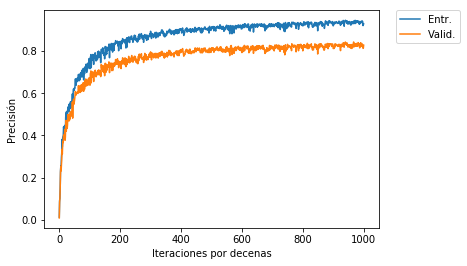

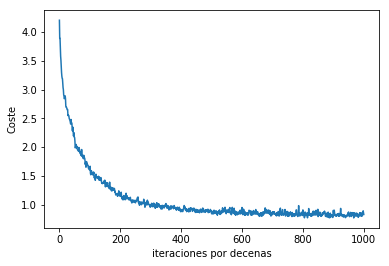

In [17]:
m2 = Model2()
train_minibatch(m2, X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, 10000, imprimir = True)

In [21]:
for i in range(6):
    print("\n Prueba nº ",i+1)
    m2 = Model2()
    train_minibatch(m2, X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, 6000, False)


 rueba nº  1
5990, Loss: 0.420  Train accuracy: 0.910
5990, Loss: 0.888  Test accuracy: 0.807

 rueba nº  2
5990, Loss: 0.417  Train accuracy: 0.911
5990, Loss: 0.881  Test accuracy: 0.811

 rueba nº  3
5990, Loss: 0.399  Train accuracy: 0.924
5990, Loss: 0.858  Test accuracy: 0.811

 rueba nº  4
5990, Loss: 0.402  Train accuracy: 0.921
5990, Loss: 0.843  Test accuracy: 0.810

 rueba nº  5
5990, Loss: 0.400  Train accuracy: 0.923
5990, Loss: 0.828  Test accuracy: 0.814

 rueba nº  6
5990, Loss: 0.433  Train accuracy: 0.912
5990, Loss: 0.863  Test accuracy: 0.808


CON 43 NODOS

In [47]:
class Model2():

    def __init__(self):
        self.graph = tf.Graph()
        with self.graph.as_default():
            #Global setp counter
            self.global_step = tf.Variable(0, trainable=False,name='global_step')
            #Placeholders
            self.images=tf.placeholder(tf.float32,(None,32, 32,3), name='images')
            self.labels=tf.placeholder(tf.int32, [None], name='labels')
            #Flatten input
            self.images_flat=tf.contrib.layers.flatten(self.images)
            #Fully connected layer
            self.logits=tf.contrib.layers.fully_connected(self.images_flat,43, lrelu)
            #Convert one hot vector to label indexes (int)
            self.predicted_labels=tf.argmax(self.logits,1)
            #Loss
            self.loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
                    logits=self.logits, labels=self.labels))
            #Training
            # Notice that we're passing the gloal_step variable as a parameter.
            # The minimize() function increments it with every training step.
            self.train=tf.train.AdamOptimizer(learning_rate=0.001)\
                        .minimize(self.loss, global_step=self.global_step)
            #Initialization
            self.init=tf.global_variables_initializer()
            #Create session
            self.session=tf.Session()
            #Run Initialization
            self.session.run(self.init)

   0, Loss: 3.868  Train accuracy: 0.012
   0, Loss: 3.843  Test accuracy: 0.010
  10, Loss: 3.654  Train accuracy: 0.068
  10, Loss: 3.681  Test accuracy: 0.061
  20, Loss: 3.585  Train accuracy: 0.117
  20, Loss: 3.618  Test accuracy: 0.122
  30, Loss: 3.536  Train accuracy: 0.138
  30, Loss: 3.553  Test accuracy: 0.129
  40, Loss: 3.465  Train accuracy: 0.162
  40, Loss: 3.494  Test accuracy: 0.155
  50, Loss: 3.383  Train accuracy: 0.209
  50, Loss: 3.416  Test accuracy: 0.196
  60, Loss: 3.380  Train accuracy: 0.152
  60, Loss: 3.442  Test accuracy: 0.150
  70, Loss: 3.306  Train accuracy: 0.195
  70, Loss: 3.346  Test accuracy: 0.178
  80, Loss: 3.233  Train accuracy: 0.254
  80, Loss: 3.280  Test accuracy: 0.245
  90, Loss: 3.270  Train accuracy: 0.210
  90, Loss: 3.345  Test accuracy: 0.201
 100, Loss: 3.183  Train accuracy: 0.260
 100, Loss: 3.221  Test accuracy: 0.246
 110, Loss: 3.143  Train accuracy: 0.287
 110, Loss: 3.204  Test accuracy: 0.268
 120, Loss: 3.084  Train acc

1020, Loss: 1.822  Train accuracy: 0.644
1020, Loss: 1.938  Test accuracy: 0.601
1030, Loss: 1.819  Train accuracy: 0.655
1030, Loss: 1.939  Test accuracy: 0.610
1040, Loss: 1.828  Train accuracy: 0.637
1040, Loss: 1.949  Test accuracy: 0.592
1050, Loss: 1.824  Train accuracy: 0.631
1050, Loss: 1.964  Test accuracy: 0.577
1060, Loss: 1.789  Train accuracy: 0.647
1060, Loss: 1.934  Test accuracy: 0.602
1070, Loss: 1.751  Train accuracy: 0.661
1070, Loss: 1.890  Test accuracy: 0.603
1080, Loss: 1.775  Train accuracy: 0.662
1080, Loss: 1.912  Test accuracy: 0.612
1090, Loss: 1.767  Train accuracy: 0.648
1090, Loss: 1.905  Test accuracy: 0.597
1100, Loss: 1.804  Train accuracy: 0.617
1100, Loss: 1.961  Test accuracy: 0.563
1110, Loss: 1.810  Train accuracy: 0.623
1110, Loss: 1.992  Test accuracy: 0.570
1120, Loss: 1.756  Train accuracy: 0.636
1120, Loss: 1.917  Test accuracy: 0.579
1130, Loss: 1.716  Train accuracy: 0.651
1130, Loss: 1.832  Test accuracy: 0.607
1140, Loss: 1.746  Train acc

2040, Loss: 1.036  Train accuracy: 0.810
2040, Loss: 1.312  Test accuracy: 0.721
2050, Loss: 1.040  Train accuracy: 0.805
2050, Loss: 1.329  Test accuracy: 0.714
2060, Loss: 1.031  Train accuracy: 0.804
2060, Loss: 1.305  Test accuracy: 0.726
2070, Loss: 1.007  Train accuracy: 0.819
2070, Loss: 1.281  Test accuracy: 0.727
2080, Loss: 0.998  Train accuracy: 0.818
2080, Loss: 1.273  Test accuracy: 0.728
2090, Loss: 1.014  Train accuracy: 0.818
2090, Loss: 1.261  Test accuracy: 0.743
2100, Loss: 1.009  Train accuracy: 0.819
2100, Loss: 1.290  Test accuracy: 0.730
2110, Loss: 1.025  Train accuracy: 0.810
2110, Loss: 1.303  Test accuracy: 0.720
2120, Loss: 1.041  Train accuracy: 0.805
2120, Loss: 1.306  Test accuracy: 0.720
2130, Loss: 1.039  Train accuracy: 0.797
2130, Loss: 1.294  Test accuracy: 0.724
2140, Loss: 1.025  Train accuracy: 0.816
2140, Loss: 1.295  Test accuracy: 0.732
2150, Loss: 1.018  Train accuracy: 0.811
2150, Loss: 1.288  Test accuracy: 0.734
2160, Loss: 1.014  Train acc

3060, Loss: 0.719  Train accuracy: 0.867
3060, Loss: 1.033  Test accuracy: 0.779
3070, Loss: 0.737  Train accuracy: 0.851
3070, Loss: 1.088  Test accuracy: 0.752
3080, Loss: 0.708  Train accuracy: 0.867
3080, Loss: 1.083  Test accuracy: 0.755
3090, Loss: 0.707  Train accuracy: 0.868
3090, Loss: 1.048  Test accuracy: 0.773
3100, Loss: 0.683  Train accuracy: 0.878
3100, Loss: 1.019  Test accuracy: 0.777
3110, Loss: 0.688  Train accuracy: 0.867
3110, Loss: 1.021  Test accuracy: 0.777
3120, Loss: 0.689  Train accuracy: 0.871
3120, Loss: 1.072  Test accuracy: 0.759
3130, Loss: 0.725  Train accuracy: 0.857
3130, Loss: 1.074  Test accuracy: 0.770
3140, Loss: 0.700  Train accuracy: 0.871
3140, Loss: 1.064  Test accuracy: 0.773
3150, Loss: 0.690  Train accuracy: 0.873
3150, Loss: 1.034  Test accuracy: 0.778
3160, Loss: 0.719  Train accuracy: 0.868
3160, Loss: 1.064  Test accuracy: 0.769
3170, Loss: 0.671  Train accuracy: 0.878
3170, Loss: 1.002  Test accuracy: 0.777
3180, Loss: 0.700  Train acc

4080, Loss: 0.545  Train accuracy: 0.888
4080, Loss: 0.939  Test accuracy: 0.787
4090, Loss: 0.561  Train accuracy: 0.888
4090, Loss: 0.944  Test accuracy: 0.782
4100, Loss: 0.553  Train accuracy: 0.889
4100, Loss: 0.943  Test accuracy: 0.786
4110, Loss: 0.556  Train accuracy: 0.896
4110, Loss: 0.913  Test accuracy: 0.794
4120, Loss: 0.581  Train accuracy: 0.885
4120, Loss: 0.982  Test accuracy: 0.779
4130, Loss: 0.537  Train accuracy: 0.902
4130, Loss: 0.903  Test accuracy: 0.806
4140, Loss: 0.555  Train accuracy: 0.893
4140, Loss: 0.898  Test accuracy: 0.804
4150, Loss: 0.563  Train accuracy: 0.889
4150, Loss: 0.936  Test accuracy: 0.792
4160, Loss: 0.547  Train accuracy: 0.892
4160, Loss: 0.950  Test accuracy: 0.788
4170, Loss: 0.542  Train accuracy: 0.897
4170, Loss: 0.945  Test accuracy: 0.793
4180, Loss: 0.548  Train accuracy: 0.894
4180, Loss: 0.931  Test accuracy: 0.801
4190, Loss: 0.553  Train accuracy: 0.893
4190, Loss: 0.946  Test accuracy: 0.799
4200, Loss: 0.552  Train acc

5100, Loss: 0.494  Train accuracy: 0.897
5100, Loss: 0.927  Test accuracy: 0.800
5110, Loss: 0.485  Train accuracy: 0.902
5110, Loss: 0.841  Test accuracy: 0.818
5120, Loss: 0.472  Train accuracy: 0.909
5120, Loss: 0.874  Test accuracy: 0.807
5130, Loss: 0.500  Train accuracy: 0.900
5130, Loss: 0.928  Test accuracy: 0.799
5140, Loss: 0.472  Train accuracy: 0.905
5140, Loss: 0.911  Test accuracy: 0.798
5150, Loss: 0.486  Train accuracy: 0.902
5150, Loss: 0.907  Test accuracy: 0.799
5160, Loss: 0.477  Train accuracy: 0.906
5160, Loss: 0.892  Test accuracy: 0.802
5170, Loss: 0.459  Train accuracy: 0.914
5170, Loss: 0.906  Test accuracy: 0.808
5180, Loss: 0.465  Train accuracy: 0.907
5180, Loss: 0.907  Test accuracy: 0.802
5190, Loss: 0.439  Train accuracy: 0.919
5190, Loss: 0.853  Test accuracy: 0.816
5200, Loss: 0.448  Train accuracy: 0.917
5200, Loss: 0.852  Test accuracy: 0.809
5210, Loss: 0.453  Train accuracy: 0.913
5210, Loss: 0.871  Test accuracy: 0.812
5220, Loss: 0.447  Train acc

6120, Loss: 0.424  Train accuracy: 0.912
6120, Loss: 0.891  Test accuracy: 0.808
6130, Loss: 0.427  Train accuracy: 0.911
6130, Loss: 0.855  Test accuracy: 0.814
6140, Loss: 0.442  Train accuracy: 0.903
6140, Loss: 0.934  Test accuracy: 0.787
6150, Loss: 0.439  Train accuracy: 0.906
6150, Loss: 0.895  Test accuracy: 0.808
6160, Loss: 0.430  Train accuracy: 0.914
6160, Loss: 0.872  Test accuracy: 0.803
6170, Loss: 0.424  Train accuracy: 0.915
6170, Loss: 0.858  Test accuracy: 0.815
6180, Loss: 0.414  Train accuracy: 0.917
6180, Loss: 0.842  Test accuracy: 0.820
6190, Loss: 0.460  Train accuracy: 0.900
6190, Loss: 0.934  Test accuracy: 0.800
6200, Loss: 0.427  Train accuracy: 0.915
6200, Loss: 0.845  Test accuracy: 0.813
6210, Loss: 0.430  Train accuracy: 0.915
6210, Loss: 0.846  Test accuracy: 0.818
6220, Loss: 0.430  Train accuracy: 0.907
6220, Loss: 0.885  Test accuracy: 0.799
6230, Loss: 0.426  Train accuracy: 0.913
6230, Loss: 0.880  Test accuracy: 0.806
6240, Loss: 0.407  Train acc

7140, Loss: 0.371  Train accuracy: 0.925
7140, Loss: 0.816  Test accuracy: 0.821
7150, Loss: 0.383  Train accuracy: 0.923
7150, Loss: 0.828  Test accuracy: 0.813
7160, Loss: 0.384  Train accuracy: 0.917
7160, Loss: 0.865  Test accuracy: 0.806
7170, Loss: 0.416  Train accuracy: 0.911
7170, Loss: 0.880  Test accuracy: 0.814
7180, Loss: 0.357  Train accuracy: 0.929
7180, Loss: 0.821  Test accuracy: 0.821
7190, Loss: 0.358  Train accuracy: 0.929
7190, Loss: 0.811  Test accuracy: 0.822
7200, Loss: 0.347  Train accuracy: 0.933
7200, Loss: 0.796  Test accuracy: 0.825
7210, Loss: 0.348  Train accuracy: 0.934
7210, Loss: 0.804  Test accuracy: 0.825
7220, Loss: 0.379  Train accuracy: 0.919
7220, Loss: 0.844  Test accuracy: 0.808
7230, Loss: 0.360  Train accuracy: 0.930
7230, Loss: 0.777  Test accuracy: 0.827
7240, Loss: 0.354  Train accuracy: 0.932
7240, Loss: 0.806  Test accuracy: 0.829
7250, Loss: 0.375  Train accuracy: 0.920
7250, Loss: 0.852  Test accuracy: 0.813
7260, Loss: 0.359  Train acc

8160, Loss: 0.363  Train accuracy: 0.921
8160, Loss: 0.851  Test accuracy: 0.819
8170, Loss: 0.343  Train accuracy: 0.928
8170, Loss: 0.793  Test accuracy: 0.827
8180, Loss: 0.381  Train accuracy: 0.917
8180, Loss: 0.845  Test accuracy: 0.817
8190, Loss: 0.334  Train accuracy: 0.933
8190, Loss: 0.833  Test accuracy: 0.821
8200, Loss: 0.341  Train accuracy: 0.929
8200, Loss: 0.829  Test accuracy: 0.822
8210, Loss: 0.345  Train accuracy: 0.928
8210, Loss: 0.826  Test accuracy: 0.821
8220, Loss: 0.338  Train accuracy: 0.927
8220, Loss: 0.820  Test accuracy: 0.822
8230, Loss: 0.329  Train accuracy: 0.933
8230, Loss: 0.815  Test accuracy: 0.823
8240, Loss: 0.327  Train accuracy: 0.937
8240, Loss: 0.814  Test accuracy: 0.827
8250, Loss: 0.337  Train accuracy: 0.930
8250, Loss: 0.807  Test accuracy: 0.831
8260, Loss: 0.347  Train accuracy: 0.929
8260, Loss: 0.854  Test accuracy: 0.817
8270, Loss: 0.330  Train accuracy: 0.932
8270, Loss: 0.800  Test accuracy: 0.831
8280, Loss: 0.343  Train acc

9180, Loss: 0.327  Train accuracy: 0.935
9180, Loss: 0.867  Test accuracy: 0.824
9190, Loss: 0.316  Train accuracy: 0.934
9190, Loss: 0.847  Test accuracy: 0.825
9200, Loss: 0.316  Train accuracy: 0.929
9200, Loss: 0.805  Test accuracy: 0.825
9210, Loss: 0.300  Train accuracy: 0.939
9210, Loss: 0.761  Test accuracy: 0.844
9220, Loss: 0.317  Train accuracy: 0.935
9220, Loss: 0.789  Test accuracy: 0.834
9230, Loss: 0.305  Train accuracy: 0.938
9230, Loss: 0.769  Test accuracy: 0.829
9240, Loss: 0.322  Train accuracy: 0.932
9240, Loss: 0.799  Test accuracy: 0.830
9250, Loss: 0.339  Train accuracy: 0.926
9250, Loss: 0.843  Test accuracy: 0.815
9260, Loss: 0.309  Train accuracy: 0.938
9260, Loss: 0.796  Test accuracy: 0.827
9270, Loss: 0.302  Train accuracy: 0.938
9270, Loss: 0.792  Test accuracy: 0.826
9280, Loss: 0.312  Train accuracy: 0.938
9280, Loss: 0.790  Test accuracy: 0.838
9290, Loss: 0.310  Train accuracy: 0.937
9290, Loss: 0.789  Test accuracy: 0.831
9300, Loss: 0.330  Train acc

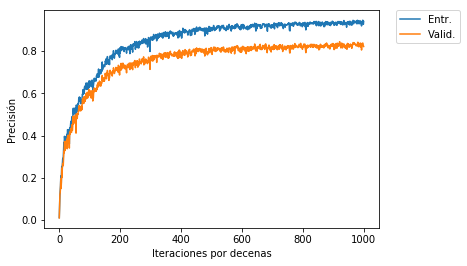

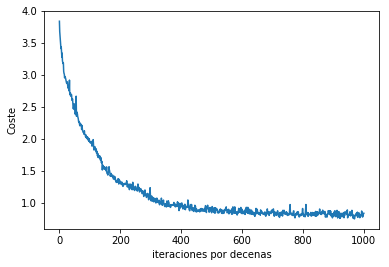

In [48]:
m2 = Model2()
train_minibatch(m2, X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, 10000, imprimir = True)

In [49]:
for i in range(6):
    print("\n Prueba nº ",i+1)
    m2 = Model2()
    train_minibatch(m2, X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, 6000, False)


 Prueba nº  1
5990, Loss: 0.422  Train accuracy: 0.917
5990, Loss: 0.843  Test accuracy: 0.819

 Prueba nº  2
5990, Loss: 0.424  Train accuracy: 0.912
5990, Loss: 0.896  Test accuracy: 0.801

 Prueba nº  3
5990, Loss: 0.443  Train accuracy: 0.904
5990, Loss: 0.909  Test accuracy: 0.800

 Prueba nº  4
5990, Loss: 0.426  Train accuracy: 0.916
5990, Loss: 0.850  Test accuracy: 0.816

 Prueba nº  5
5990, Loss: 0.413  Train accuracy: 0.917
5990, Loss: 0.848  Test accuracy: 0.814

 Prueba nº  6
5990, Loss: 0.434  Train accuracy: 0.907
5990, Loss: 0.909  Test accuracy: 0.799


## 3. VISUALIZACIÓN DE LOS PESOS

In [50]:
def normalize(image):
    return (image-image.min())/(image.max()-image.min())

def display_images(images, titles=None, cols=5, interpolation=None):
    """ 
    images: A list of images. It can be either:
        + A list of Numpy arrays. Each array represents an image.
        + A list of lists of numpy arrays. In this casse, the images in the inner
          the inner lists are concatentated to make one image.
    
    """
    
    titles = titles or [""] * len(images)
    rows = math.ceil(len(images)/(cols))
    height_ratio =1.2*(rows/cols)*(0.5 if type(images[0]) is not np.ndarray else 1)
    plt.figure(figsize=(11,11 * height_ratio))
    i=1
    for image, title in zip(images, titles):
        plt.subplot(rows, cols, i)
        plt.axis("off")
        if type(image) is not np.ndarray:
            image = [normalize(g) for g in image]
            image = np.concatenate(image, axis=1)
        else:
            image = normalize(image)
        plt.title(title, fontsize = 9)
        plt.imshow(image, cmap="Greys_r", interpolation=interpolation)
        i += 1

In [51]:
#label_exemplars= [X_train_orig[np.where(Y_train_orig == l)][:][:] for l in range(62)]
label_exemplars =[]
for i in range(43):
    for w in range(len(Y_train_orig)):
        if Y_train_orig[w] == i:
            label_exemplars.append(X_train_orig[w])
            break
#label_counts = [np.count_nonzero(X_train_orig ==l ) for l in range(62)]
label_counts = []
for i in range(43):
    label_counts.append(0)
    for w in range(len(Y_train_orig)):
        if Y_train_orig[w] == i:
            label_counts[i] = label_counts[i]+1

In [52]:
# Loop trough the graph and print the names and shapes of all trainable variables
with m2.graph.as_default():
    for v in tf.trainable_variables():
        print(v.name, v.get_shape())

fully_connected/weights:0 (3072, 43)
fully_connected/biases:0 (43,)


In [53]:
#Get the values of the weight and bias variables.
m1_weights=m2.session.run("fully_connected/weights:0")
m1_biases=m2.session.run("fully_connected/biases:0")
print("weights shape: {!s:10}    min: {:.4f}    max: {:.4f}".format(m1_weights.shape, m1_weights.min(), m1_weights.max()))
print("biases shape: {!s:10}    min: {:.4f}    max: {:.4f}".format(m1_biases.shape, m1_biases.min(), m1_biases.max()))
print("Longitud de columna: ",len(m1_weights[:,0]))
print("Primera columna: ",m1_weights[:,0])

weights shape: (3072, 43)    min: -1.4513    max: 1.0710
biases shape: (43,)         min: -0.7736    max: 1.3251
Longitud de columna:  3072
Primera columna:  [-0.07156882 -0.06160823 -0.098493   ... -0.0375348   0.04589076
  0.02320723]


In [54]:
def display_weights(weights, limit):
    titles= ["Categoría {}  ({})".format(l,c) for l, c in enumerate(label_counts)]
    images = list(zip(label_exemplars, weights.T.reshape(-1, 32, 32,3)))
    display_images(images[:limit], titles)

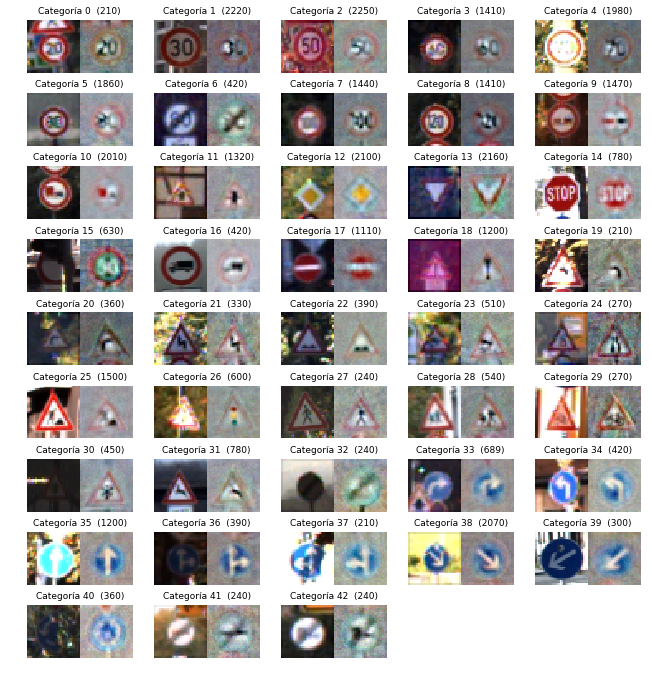

In [55]:
# Display weights of the first 30 labels
display_weights(m1_weights, 43)

Vamos a echar un vistazo a los histogramas

In [56]:
def display_histograms(weights, title):
    cols = 5
    rows = math.ceil(len(weights[0])/(cols))
    height_ratio =1.2*(rows/cols)*(0.5 if type(weights[0]) is not np.ndarray else 1)
    plt.figure(figsize=(14,14 * 1))
    for i in range(len(weights[0])):
        plt.subplot(rows,cols,i+1)
        w = weights[:,i]
        plt.title(title[i], fontsize=12)
        plt.tick_params(labelsize=6)
        plt.yticks([])
        plt.xticks([w.min(),w.max()])
        plt.hist(w, bins=62)
    plt.tight_layout()

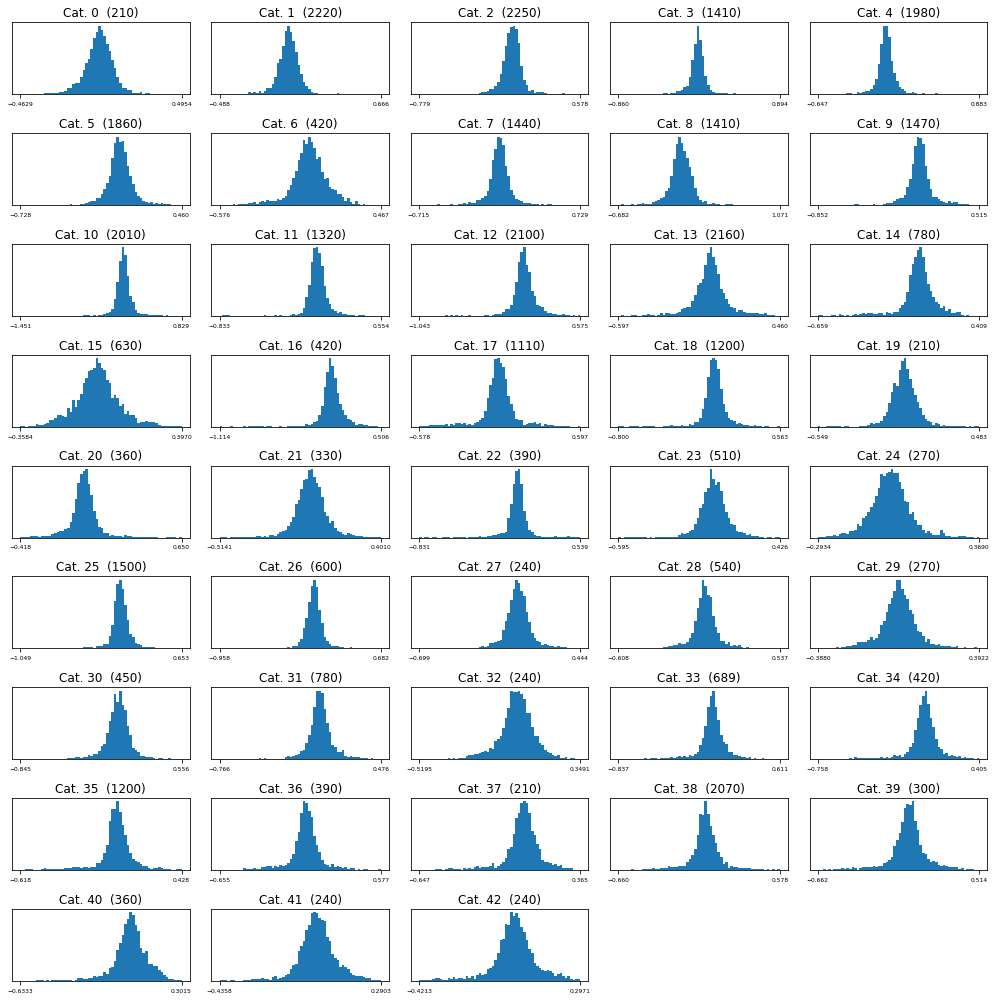

In [57]:
titles= ["Cat. {}  ({})".format(l,c) for l, c in enumerate(label_counts)]
display_histograms(m1_weights, titles)

## 4. CONFUSSION MATRIX

In [58]:
print(__doc__)

#import sklearn
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

Automatically created module for IPython interactive environment


In [65]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Matriz de confusión del subconjunto de entrenamiento',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusión del subconjunto de entrenamiento")
    else:
        print('Matriz de confusión del subconjunto de entrenamiento')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=12)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Matriz de confusión del subconjunto de entrenamiento
[[ 11  47   0 ...   0   0   0]
 [  0 652  21 ...   0   0   0]
 [  1  86 617 ...   0   0   0]
 ...
 [  0   0   0 ...  55   0   0]
 [  0   0   0 ...   0  38   0]
 [  0   0   1 ...   0   0  46]]


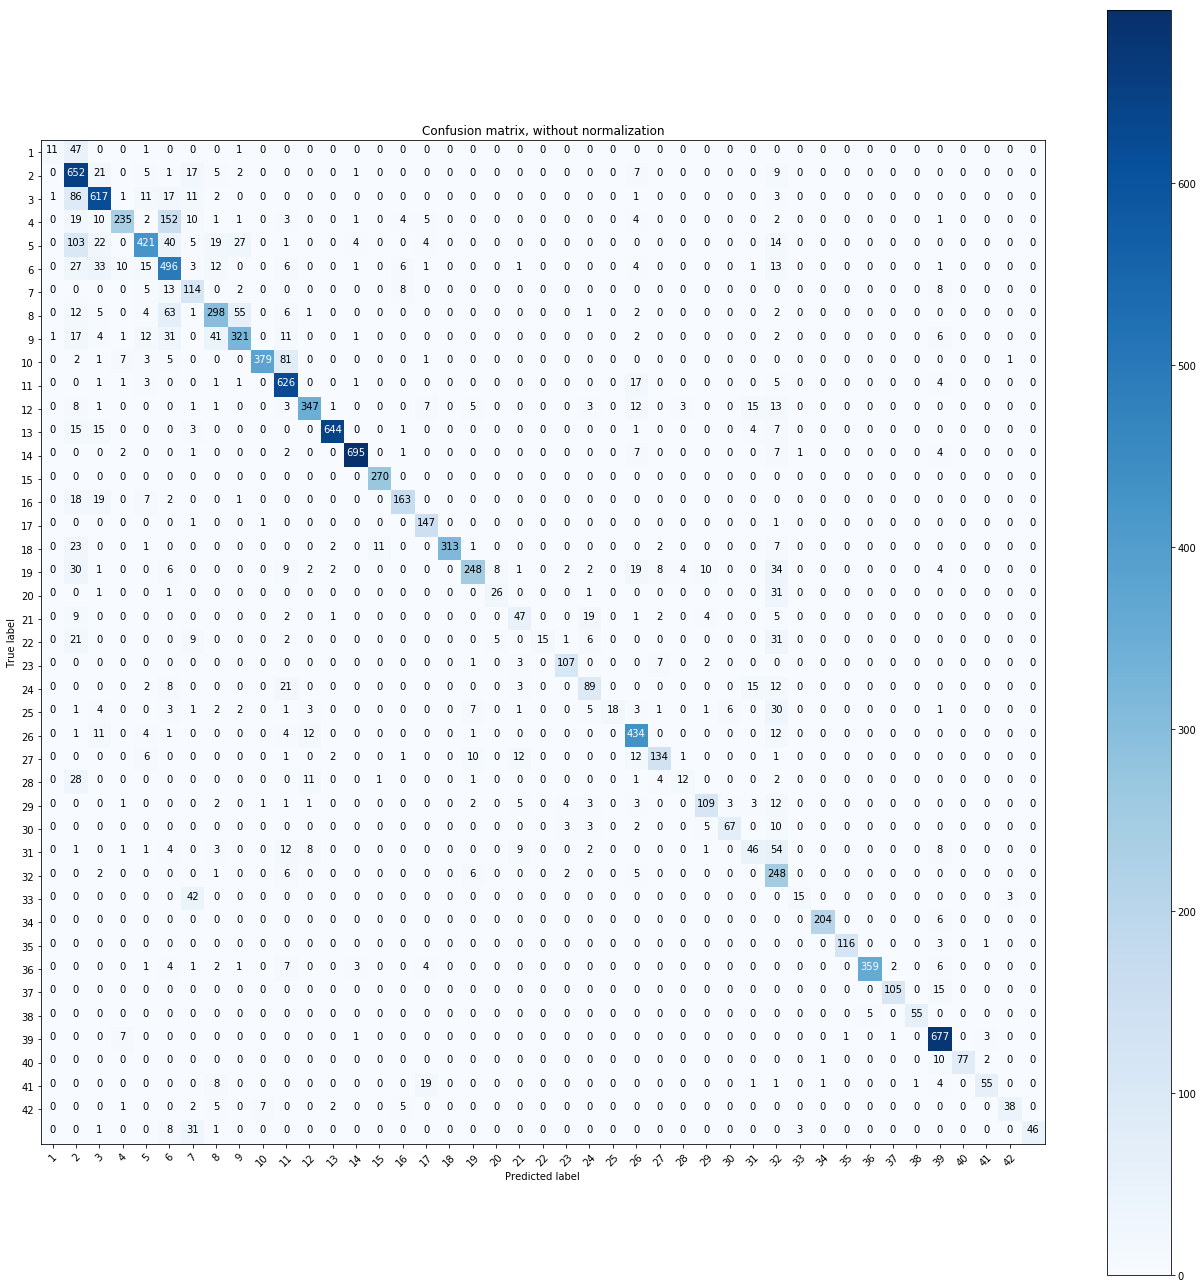

In [66]:
y_pred, _ = m2.session.run([m2.predicted_labels, m2.loss],
                                       {m2.images: X_test_orig, m2.labels:Y_test_orig})

y_test = Y_test_orig

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

class_names= list(range(1,43))

#Plot non-normalized confusion matrix
plt.figure(figsize=(18,18))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')


plt.show()

## 5. PORCENTAJE DE ACIERTOS

In [43]:
def display_aciertos(images, titles=None, cols=5, interpolation=None):
    """ 
    images: A list of images. It can be either:
        + A list of Numpy arrays. Each array represents an image.
        + A list of lists of numpy arrays. In this casse, the images in the inner
          the inner lists are concatentated to make one image.
    
    """
    
    titles = titles or [""] * len(images)
    rows = math.ceil(len(images)/(cols))
    height_ratio =1.2*(rows/cols)*(0.5 if type(images[0]) is not np.ndarray else 1)
    plt.figure(figsize=(11,11 * height_ratio))
    i=1
    for image, title in zip(images, titles):
        plt.subplot(rows, cols, i)
        plt.axis("off")
        if type(image) is not np.ndarray:
            image = [normalize(g) for g in image]
            image = np.concatenate(image, axis=1)
        else:
            image = normalize(image)
        plt.title(title, fontsize = 10)
        plt.imshow(image, cmap="Greys_r", interpolation=interpolation)
        i += 1

In [24]:
label_exemplars_test =[]
for i in range(43):
    for w in range(len(Y_test_orig)):
        if Y_test_orig[w] == i:
            label_exemplars_test.append(X_test_orig[w])
            break

In [26]:
label_count_test = []
for i in range(43):
    label_count_test.append(0)
    for w in range(len(Y_test_orig)):
        if Y_test_orig[w] == i:
            label_count_test[i] = label_count_test[i]+1

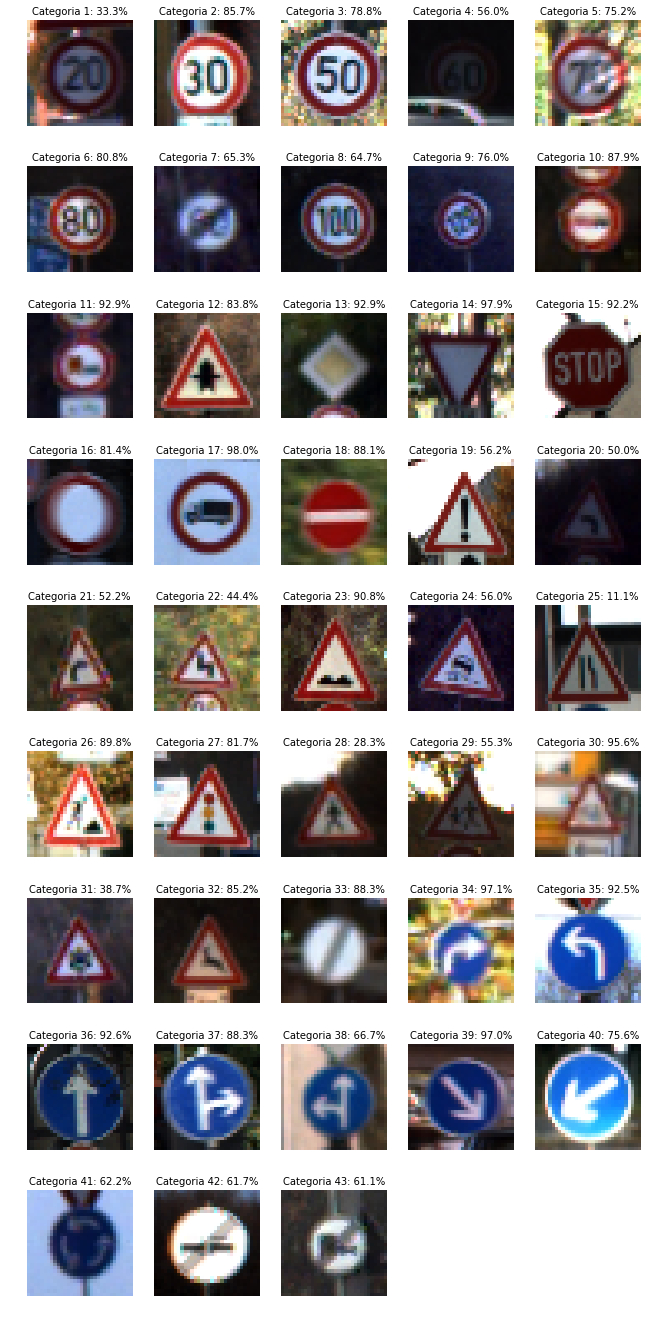

In [79]:
aciertos = [round(cnf_matrix[i,i]/label_count_test[i]*100,1) for i in range(43)]
aciertos = [str(round(cnf_matrix[i,i]/label_count_test[i]*100,1)) for i in range(43)]
titles = [("Categoria "+str(i+1)+": "+aciertos[i]+"%") for i in range(43)]
display_aciertos(label_exemplars_test, titles)